In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import shutil
import os

folder_name = "cropped_img_512/.ipynb_checkpoints"

# Check if the folder exists before deleting it
if os.path.exists(folder_name):
    # Use shutil.rmtree to remove the folder and all of its contents
    shutil.rmtree(folder_name)
    print(f"{folder_name} folder and its contents have been deleted.")
else:
    print(f"{folder_name} folder does not exist.")


cropped_img_512/.ipynb_checkpoints folder does not exist.


In [4]:
raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, 'r', driver = 'JP2OpenJPEG') as src:
    raster_img = src.read()
    raster_meta = src.meta

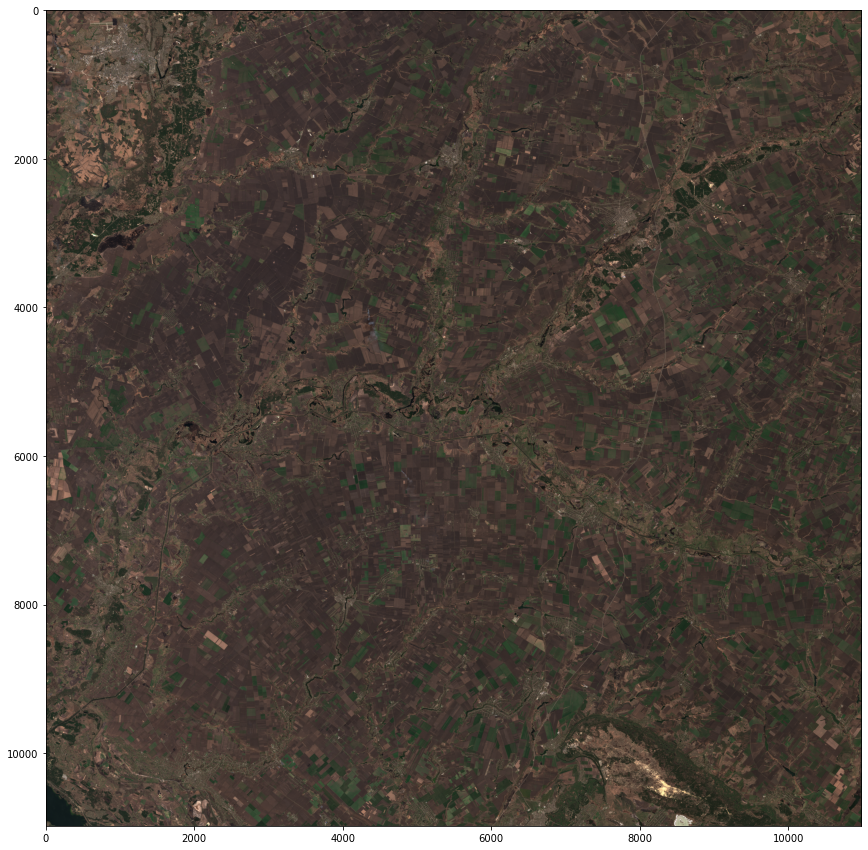

In [5]:
raster_img = reshape_as_image(raster_img)

plt.figure(figsize=(15,15))
plt.imshow(raster_img)

In [6]:
train_df = gpd.read_file("Masks_T36UXV_20190427.shp")
print(len(train_df))
train_df.head(5)

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



936


id  Data  Code       Descriptio Comments                   Image  \
0 NaN   NaN   2.0   branch of tree      NaN  T36UXV_20190427T083601   
1 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   
2 NaN   NaN   2.0   brahch of tree      NaN  T36UXV_20190427T083601   
3 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   
4 NaN   NaN   1.0  color+ feathers      NaN  T36UXV_20190427T083601   

                                            geometry  
0  POLYGON ((35.62916 49.60293, 35.63015 49.60163...  
1  POLYGON ((35.65070 49.60254, 35.65248 49.60301...  
2  POLYGON ((35.63023 49.60826, 35.62960 49.60920...  
3  POLYGON ((35.62033 49.60905, 35.62064 49.60968...  
4  POLYGON ((35.60455 49.61078, 35.60597 49.61228...

In [7]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

In [8]:
train_df = gpd.read_file("Masks_T36UXV_20190427.shp")


train_df = train_df[train_df.geometry.notnull()]

train_df.crs = {'init' :'epsg:4324'}

train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<ipython-input-9-e7a5875f2f75>:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


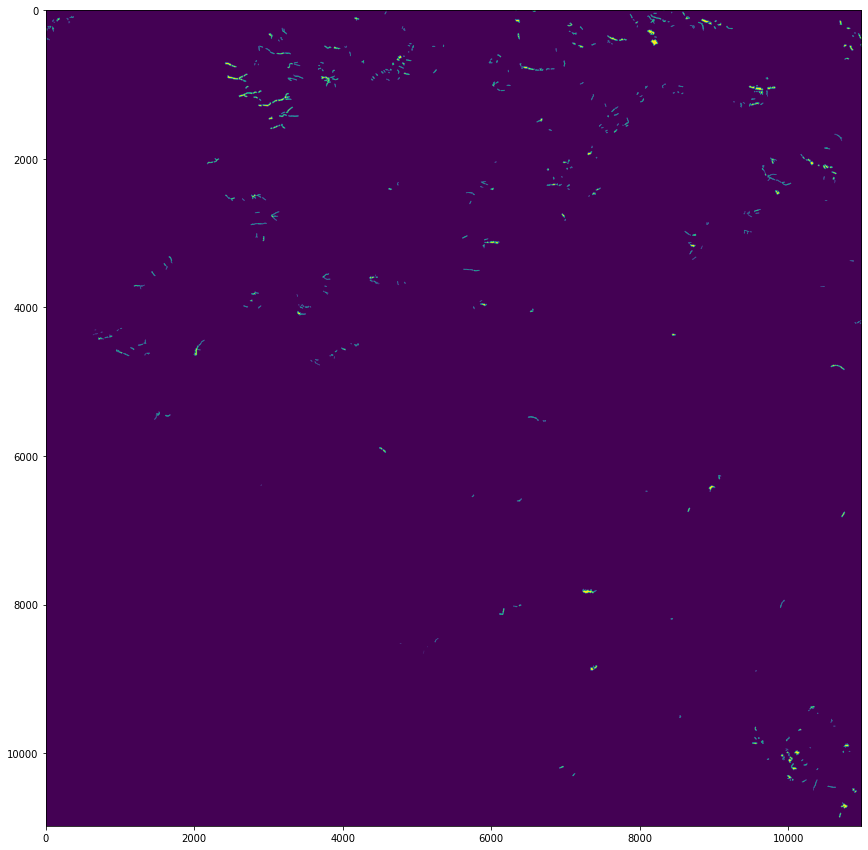

In [9]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

In [10]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("big_mask.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

#### CROP

In [11]:
raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, 'r', driver = 'JP2OpenJPEG') as src:
    big_img = src.read()
    img_meta = src.meta

In [ ]:
raster_path = 'big_mask.jp2'
with rasterio.open(raster_path, 'r', driver = 'JP2OpenJPEG') as src:
    big_mask = src.read()
    mask_meta = src.meta

In [12]:
big_img = reshape_as_image(big_img)
big_mask = reshape_as_image(big_mask)

In [13]:
big_img = reshape_as_image(big_img)
big_mask = reshape_as_image(big_mask)

In [14]:
def batch_crop(big_img, shape, outfolder):
    i = 0
    for r in range(0,big_img.shape[0],shape[0]):
        for c in range(0,big_img.shape[1],shape[1]):
            img_path = os.path.join(outfolder, f'{i}.png')
            if r+shape[0] <= big_img.shape[0] and c + shape[1] <= big_img.shape[1]:
                cv2.imwrite(img_path, cv2.cvtColor(big_img[r:r+shape[0], c:c+shape[1],:], cv2.COLOR_RGB2BGR))
                i += 1

In [15]:
#cropped_img_256
batch_crop(big_img, (256, 256), "cropped_image_shape_256")

#cropped_mask_256
batch_crop(big_mask, (256, 256), "cropped_mask_shape_256")

#### EXPLANATORY DATA ANALYSIS

In [16]:
def load_images(train_dir, mask_dir, train_list, mask_list, mode='limited'):
    images, masks = [], []

    empty_mask_counter = 0

    for train_img, mask_img in zip(train_list, mask_list):
        train_path = os.path.join(train_dir, train_img)
        mask_path = os.path.join(mask_dir, mask_img)
        print(f"Loading image: {train_path}")

        img = cv2.cvtColor(cv2.imread(train_path), cv2.COLOR_BGR2RGB) / 255.0
        mask = cv2.imread(mask_path)[:, :, :1]
        mask[mask > 0] = 1

        if mode == 'limited' and 1 not in mask:
            empty_mask_counter += 1
            if empty_mask_counter >= 40:
                continue
        
        images.append(img)
        masks.append(mask)

    images = np.array(images, dtype='float32')
    masks = np.array(masks, dtype='float32')

    if mode == 'limited':
        return images, masks
    elif mode == 'not_limited':
        return images, masks, empty_mask_counter


In [17]:
train_direction =  'cropped_image_shape_256/'
mask_direction = 'cropped_mask_shape_256/'

train = sorted(os.listdir(train_direction))
mask = sorted(os.listdir(mask_direction))


all_rgb_256, all_mask_256, c_256 = load_images(train_direction,\
                                                mask_direction, train, mask, mode = 'not_limited')

rgb_256, mask_256 = load_images(train_direction, mask_direction,\
                                 train, mask, mode = 'limited')


Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/0.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/10.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/100.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1000.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1001.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1002.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1003.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1004.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1005.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1006.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1007.png
Loading image: /content/drive/MyDrive/task_4/cropped_image_shape_256/1008

#### Pixel ratio

In [18]:
def pixel_ratio(masks):
    total_pixels = masks.shape[0] * masks.shape[1]
    mask_pixels = np.sum(masks > 0)
    return mask_pixels / total_pixels

In [19]:
all_ratio_256 = pixel_ratio(all_mask_256)
ratio_256 = pixel_ratio(mask_256)

In [21]:
x = np.array([all_ratio_256,ratio_256])
y = np.array([all_ratio_256,ratio_256])

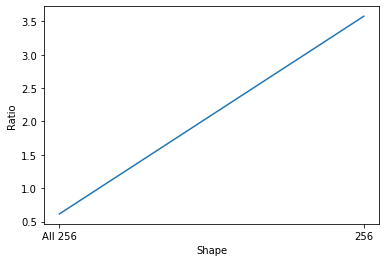

In [22]:
xticks = ['All 256','256']
plt.xticks(x, xticks)
plt.xlabel('Shape')
plt.ylabel('Ratio')
plt.plot(x, y)
plt.show()

#### MASKS PROBLEM

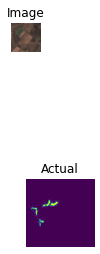

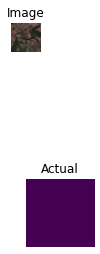

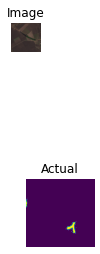

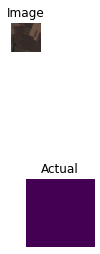

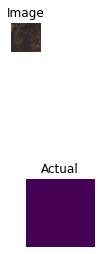

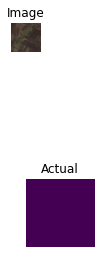

In [23]:

for i in np.arange(1,7,1):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(11, 3, 1)
    plt.imshow(rgb_256[i])
    plt.axis('off')
    plt.title("Image")
    
    fig.add_subplot(1, 7, 2)
    plt.imshow(mask_256[i], interpolation=None)
   
    plt.axis('off')
    plt.title("Actual")